In [83]:
import sys
import os
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import numpy as np
import itertools
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

# Get current working directory and go up one level to project root
PROJECT_ROOT = Path(os.getcwd()).parent
sys.path.insert(0, str(PROJECT_ROOT))

from src.llm_application import LLMAccountant, row2doc, doc2lancamento

In [84]:
df = pd.read_csv(PROJECT_ROOT / "data" / "input_com_categorias.csv")

In [85]:
dev_df, holdout_df = train_test_split(df, test_size=0.3, random_state=42)

In [86]:
k_range = range(3, 15)
threshold_range = [i/10 for i in range(5, 10)]
grid = list(itertools.product(k_range, threshold_range))

### O _cross-validation_ é apenas uma prova de conceito. A base de dados é muito pequena para apresentar alguma significância.

In [ ]:
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracy_estimates = []
for k, threshold in tqdm(grid):
    accuracy_buffer = []
    for fold, (train_idx, val_idx) in enumerate(stratified_kfold.split(dev_df, dev_df['Conta Contábil'])):
        train_fold = dev_df.iloc[train_idx]
        val_fold = dev_df.iloc[val_idx]

        accountant = LLMAccountant(threshold=threshold, k=k)
        train_docs = [row2doc(row) for row in train_fold.iterrows()]
        accountant.add_source_of_truth(train_docs)

        val_docs = [row2doc(row) for row in val_fold.iterrows()]
        val_lancamentos = [doc2lancamento(doc) for doc in val_docs]

        output = accountant.batch(val_lancamentos)

        y_pred = [out['category'].category for out in output]
        y = val_fold['Conta Contábil']
        accuracy_buffer.append(accuracy_score(y, y_pred))
    accuracy_estimates.append(np.mean(accuracy_buffer))

  0%|          | 0/60 [00:00<?, ?it/s]

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=5532710b-55cf-4479-97ba-a19e060d0579,id=5532710b-55cf-4479-97ba-a19e060d0579; trace=5532710b-55cf-4479-97ba-a19e060d0579,id=6b45359b-7943-47d5-a508-c1ade0a07203; trace=5532710b-55cf-4479-97ba-a19e060d0579,id=f586a40d-696a-4e4b-95eb-6194b3c6cac4; trace=bbed2be4-719b-4c2e-bdd7-18a742d4da95,id=bbed2be4-719b-4c2e-bdd7-18a742d4da95; trace=f77600d1-f1b7-40b6-bb07-f3c8982100c9,id=f77600d1-f1b7-40b6-bb07-f3c8982100c9; trace=4a79e7e7-ac94-4672-801f-68282adbbea6,id=4a79e7e7-ac94-4672-801f-68282adbbea6; trace=4a2103ca-0c82-423b-9270-cffd4ecf79ad,id=4a2103ca-0c82-423b-9270-cffd4ecf79ad; trace=bbed2be4-719b-4c2e-bdd7-18a742d4da95

In [ ]:
best_params = grid[np.argmax(accuracy_estimates)]
best_params

(5, 0.8)

`best_params = (5, 0.8)`

0.7, 10

In [ ]:
best_accountant = LLMAccountant(threshold=0.7, k=10)
dev_docs = [row2doc(row) for row in dev_df.iterrows()]
accountant.add_source_of_truth(dev_docs)

In [ ]:
holdout_docs = [row2doc(row) for row in holdout_df.iterrows()]
holdout_lancamentos = [doc2lancamento(doc) for doc in holdout_docs]

output = accountant.batch(holdout_lancamentos)
y_pred = [out['category'].category for out in output]
y = holdout_df['Conta Contábil']

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=7250a6a6-def9-4704-a25c-bc6dda826373,id=7250a6a6-def9-4704-a25c-bc6dda826373; trace=7250a6a6-def9-4704-a25c-bc6dda826373,id=5b675d13-90ff-40a1-8cc4-58745eab5cd5; trace=7250a6a6-def9-4704-a25c-bc6dda826373,id=db253e4e-0cdd-4a0c-8ba4-f4aab81c0438; trace=240610c3-b934-47f4-9197-d4c000b12d3b,id=240610c3-b934-47f4-9197-d4c000b12d3b; trace=240610c3-b934-47f4-9197-d4c000b12d3b,id=b3d3b0f7-62f2-4278-95ca-04d9eb6d6776; trace=240610c3-b934-47f4-9197-d4c000b12d3b,id=bdfa3c21-40e9-4305-a1a3-14b876ae3f02; trace=babc1382-25bb-421c-9911-e61cef49b17f,id=babc1382-25bb-421c-9911-e61cef49b17f; trace=babc1382-25bb-421c-9911-e61cef49b17f

In [ ]:
print(classification_report(y, y_pred))

                                     precision    recall  f1-score   support

                  Despesa - Aluguel       1.00      1.00      1.00         3
Despesa - Assinaturas e Publicações       1.00      1.00      1.00         1
Despesa - Benefícios a Funcionários       1.00      1.00      1.00         4
              Despesa - Combustível       1.00      1.00      1.00         2
       Despesa - Correios e Malotes       1.00      1.00      1.00         2
             Despesa - Deslocamento       1.00      0.50      0.67         2
 Despesa - Despesas Administrativas       1.00      1.00      1.00         1
                      Despesa - Gás       0.00      0.00      0.00         1
         Despesa - Impostos e Taxas       1.00      1.00      1.00         1
                 Despesa - Internet       1.00      0.50      0.67         2
       Despesa - Manutenção Predial       1.00      0.25      0.40         4
  Despesa - Marketing e Publicidade       1.00      1.00      1.00         

Failed to send compressed multipart ingest: langsmith.utils.LangSmithRateLimitError: Rate limit exceeded for https://api.smith.langchain.com/runs/multipart. HTTPError('429 Client Error: Too Many Requests for url: https://api.smith.langchain.com/runs/multipart', '{"error":"Too many requests: tenant exceeded usage limits: Monthly unique traces usage limit exceeded"}\n')trace=0702bb13-e56a-4168-a770-c4283c473726,id=cca6efd9-77e4-4e08-bf06-b8f93b8383de; trace=0702bb13-e56a-4168-a770-c4283c473726,id=a433aee8-5edc-4c1c-9e78-a4ab54959a29; trace=0702bb13-e56a-4168-a770-c4283c473726,id=0702bb13-e56a-4168-a770-c4283c473726


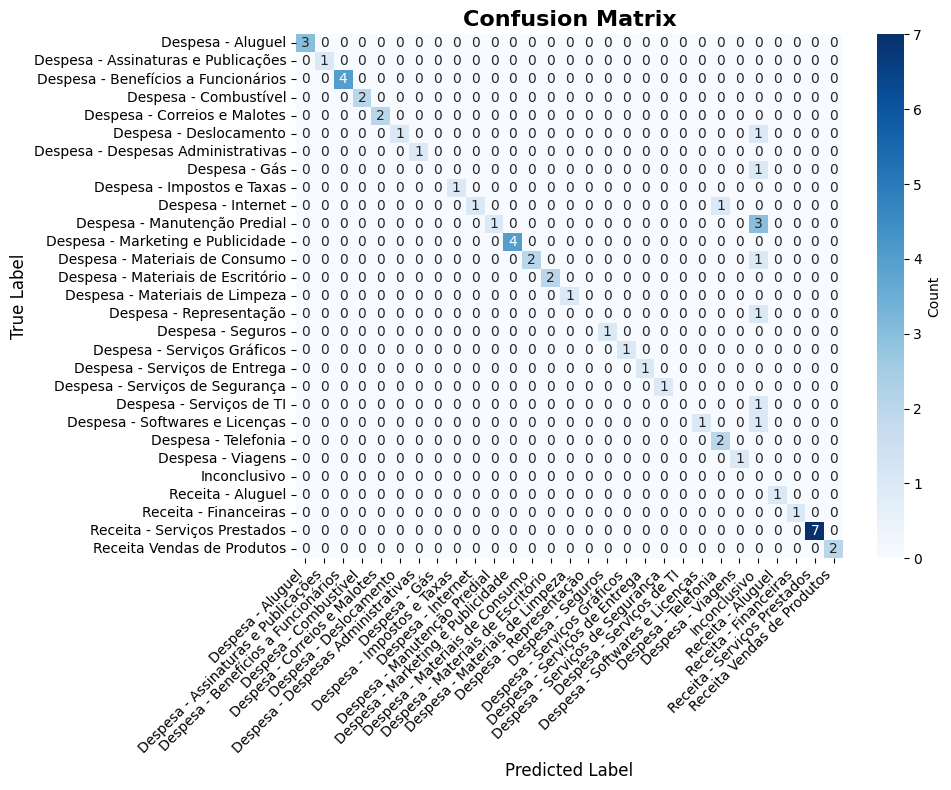


Accuracy: 0.8182


In [ ]:
# Calculate confusion matrix
cm = confusion_matrix(y, y_pred)

# Get unique labels for proper ordering
labels = sorted(list(set(y) | set(y_pred)))

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar_kws={'label': 'Count'})

plt.title('Confusion Matrix', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print accuracy
from sklearn.metrics import accuracy_score
print(f"\nAccuracy: {accuracy_score(y, y_pred):.4f}")

Accuracy: 0.7027

# Oportunidades de melhoria:

### 1. Aqui foi selecionado o melhor modelo em termos de acurácia, mas isso não significa que este seja o melhor modelo para a aplicação. Devemos levar em conta que o LLM classifica melhor que o KNN na maioria dos casos, mas, ao mesmo tempo, apresenta um custo de execução ordens de magnitude mais alto. Uma futura aplicação dessa ideia deve considerar esse fator. Integrações com o `LangSmith` podem ajudar a encontrar um ótimo no problema do custo de geração das classes.

### 2. E possivel melhorar o algoritmo KNN testando diferentes metricas de similaridade.